## Esktrakcja cech

In [9]:
import os.path
from pathlib import Path
import pandas as pd

path = '/Users/kacperskurski/DataspellProjects/Soybean_Disease_Leaf_Classification/augumentation'

image_dir = Path(path)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [18]:
import os
import cv2
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.feature import canny
from skimage.exposure import rescale_intensity
import numpy as np

def save_feature_image(image, op_path, method, file_suffix=''):
    method_path = os.path.join(op_path, method)
    if not os.path.exists(method_path):
        os.makedirs(method_path)
    save_path = os.path.join(method_path, f"{file_suffix}")
    if method != 'log' and 'canny':
        image_rescaled = (image - image.min()) / (image.max() - image.min()) * 255
        image = image_rescaled.astype('uint8')
    cv2.imwrite(save_path, image)

def lbp_feature(image, op_path, filename):
    lbp_image = local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_image = 255 - lbp_image
    save_feature_image(lbp_image, op_path, 'lbp', filename)

def canny_feature(image, op_path, filename):
    canny_img = canny(image, sigma=1.0)
    canny_image = (canny_img.astype(np.uint8) * 255).astype(np.uint8)
    save_feature_image(canny_image, op_path, 'canny', filename)

def hog_feature(image, op_path, filename):
    features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    hog_image_rescaled = rescale_intensity(hog_image, in_range=(0, 10))
    save_feature_image(hog_image_rescaled, op_path, 'hog', filename)

def log_feature(image, op_path, filename):
    log_image = cv2.Laplacian(image, cv2.CV_16S, ksize=3)
    save_feature_image(log_image, op_path, 'log', filename)


op_path_base = '/Users/kacperskurski/DataspellProjects/Soybean_Disease_Leaf_Classification/feature_extraction/'

for row in image_df.itertuples(index=False):
    original_file = cv2.imread(row.Filepath)
    img = cv2.cvtColor(original_file, cv2.COLOR_BGR2GRAY)
    filename = os.path.basename(row.Filepath)
    op_path = os.path.join(op_path_base, row.Label)
    lbp_feature(img, op_path, filename)
    log_feature(img, op_path, filename)
    canny_feature(img, op_path, filename)
    hog_feature(img, op_path, filename)

In [19]:
import os.path
from pathlib import Path
import pandas as pd

path = '/Users/kacperskurski/DataspellProjects/Soybean_Disease_Leaf_Classification/feature_extraction/'

image_dir = Path(path)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.png'))

features = [os.path.split(os.path.dirname(x))[1] for x in filepaths]
labels = [os.path.split(os.path.split(os.path.dirname(x))[0])[1] for x in filepaths]

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
features = pd.Series(features, name='Feature')

image_df_features = pd.concat([filepaths, labels, features], axis=1)

## Trening modelu

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [20]:
import cv2
import numpy as np

X = np.array([cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY).flatten() for image_path in image_df_features.Filepath.values if cv2.imread(image_path) is not None])
y = np.array(image_df_features.Label)

In [ ]:
from scipy.interpolate import interp1d


# def extract_normalized_color_histogram(image, bins=256):
#     hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# 
#     hist_hue = cv2.calcHist([hsv_image], [0], None, [bins], [0, bins])
#     hist_saturation = cv2.calcHist([hsv_image], [1], None, [bins], [0, bins])
#     hist_value = cv2.calcHist([hsv_image], [2], None, [bins], [0, bins])
# 
#     hist_hue = cv2.normalize(hist_hue, hist_hue).flatten()
#     hist_saturation = cv2.normalize(hist_saturation, hist_saturation).flatten()
#     hist_value = cv2.normalize(hist_value, hist_value).flatten()
#     color_histogram = np.concatenate([hist_hue, hist_saturation, hist_value])
#     interpolated_histogram = interp1d(np.linspace(0, 1, len(color_histogram)), color_histogram)(np.linspace(0, 1, 40000))
# 
#     return interpolated_histogram

# histograms = []
# labels = []
# 
# for row in image_df.itertuples(index=False):
#     original_file = cv2.imread(row.Filepath)
#     histograms.append(extract_normalized_color_histogram(original_file))
#     labels.append(row.Label)
# 
# 
# X = np.concatenate([X, np.array(histograms)])
# 
# y = np.concatenate([y, np.array(labels)])

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def conf_matrix(y_test, y_pred, classifier):
    # cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
    cm = confusion_matrix(y_test, y_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='gist_heat')
    plt.show()
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model accuracy: {accuracy}')
    
    f_1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 score: {f_1}')

# Trening modeli

In [23]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## SGD model

In [24]:
model_sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
model_sgd.fit(X_train_scaled, y_train)

y_pred_sgd = model_sgd.predict(X_test_scaled)

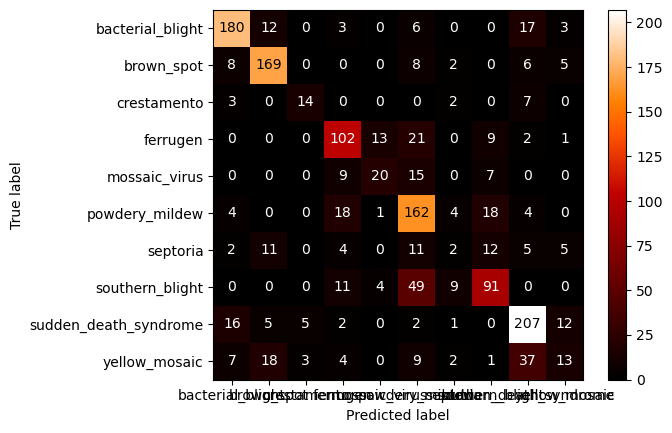

Model accuracy: 0.6784452296819788
F1 score: 0.6591612758032456


In [25]:
conf_matrix(y_test, y_pred_sgd, model_sgd)

## SVC model

In [26]:
from sklearn.svm import SVC

svc_model = SVC(random_state=42)
svc_model.fit(X_train_scaled, y_train)

y_pred_svc = svc_model.predict(X_test_scaled)

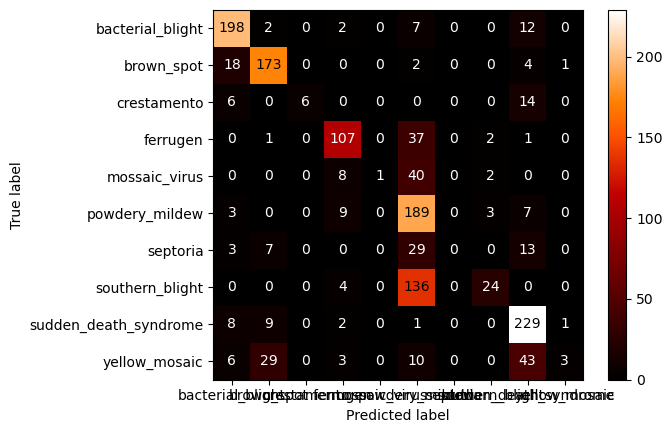

Model accuracy: 0.657243816254417
F1 score: 0.5954217626425278


In [27]:
conf_matrix(y_test, y_pred_svc, svc_model)

## DecisionTree model

In [30]:
from sklearn.tree import DecisionTreeClassifier


dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred_dt = dt_model.predict(X_test_scaled)

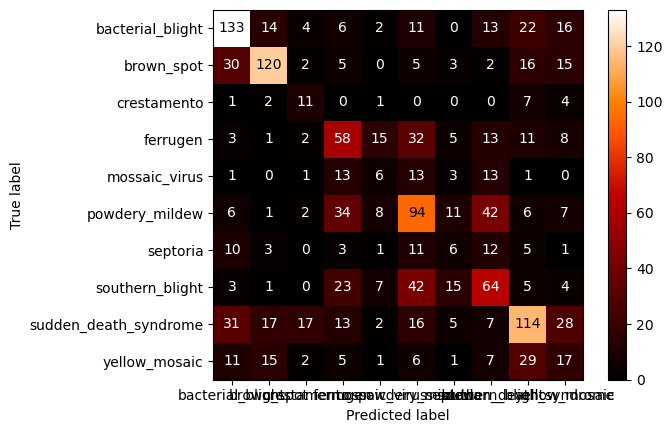

Model accuracy: 0.4402826855123675
F1 score: 0.442669016444136


In [31]:
conf_matrix(y_test, y_pred_dt, dt_model)

## Optymalizacja

In [19]:
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_


Najlepsze hiperparametry: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}


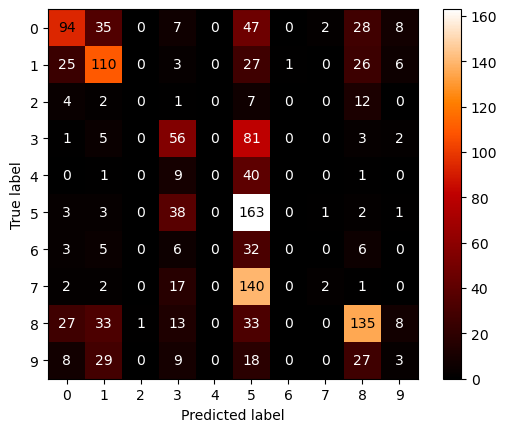

Model accuracy: 0.3978798586572438
F1 score: 0.350617628968066


In [41]:
print("Najlepsze hiperparametry:", grid_search.best_params_)

y_pred = grid_search.predict(X_test_scaled)

conf_matrix(y_test, y_pred, model)
